# MODEL Testing:

- It involves loading the tranied model file (.h5 format).
- Also loading layers (building layers again)
- To test **15** images of both the classes (cats & dogs as asked)
---

## Importing dependencies:

In [117]:
import numpy as np
import cv2
import os 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from keras.metrics import Accuracy

from keras.callbacks import ModelCheckpoint

In [118]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

---

In [119]:
# Defining constants
IMG_WIDTH = 128
IMG_HEIGHT = 128
NUM_CHANNELS = 3   # 3 channels - coloured images 
NUM_CLASSES = 2    # 2 classes - cats & dogs
BATCH_SIZE = 32
EPOCHS = 50

---

## Importing Trained Model weights and building layers:

- This type of technique can also be useful in distributed learning.

### Layer building & compiling model:

In [120]:
model = Sequential()

# 1st Conv. Layer : 32 Filters of 3x3 size with i/p shape:(224,224,3) & Maximum pooling into size 2x2
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, NUM_CHANNELS) ))
model.add(MaxPool2D(pool_size=(2,2)))

# 2nd Conv. Layer : 64 Filters of 3x3 size & Max. pooling into 2x2 size
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# Flattening the o/p of conv layers to single vector
model.add(Flatten())

# Adding Dense layers (Can be added as required)
model.add(Dense(64, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax')) # final outpu layer containing two classes cats and dogs

In [121]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 57600)             0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [122]:
# COMPILING the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Loading Saved Trained model:

In [123]:
model.load_weights("model_chckpnt_woImanip.h5")

---

# Loading Test Data:

In [124]:
os.listdir('./test_dataset/')

# 15 set of each type of data (cats and dogs)

['cats_0', 'dogs_1']

In [125]:
cats_path = './test_dataset/cats_0'
dogs_path = './test_dataset/dogs_1'

In [126]:
def load_data(direc, label):
    imgs = []
    for file in os.listdir(direc):
        path = os.path.join(direc, file)
        img = cv2.imread(path)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        imgs.append([img, label])
    return imgs

In [127]:
cats_data = load_data(cats_path, 0)
dogs_data = load_data(dogs_path, 1)
len(cats_data)

15

In [128]:
# Combining test data:
test_data = cats_data + dogs_data

# Shuffling data:
np.random.seed(30)
np.random.shuffle(test_data)

# converting to array
X_test = []
y_test = []
for img, label in test_data:
    X_test.append(img)
    y_test.append(label)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_test.shape

(30, 128, 128, 3)

---

## Preprocessing Test Image Data:

In [129]:
def preprocess_data(img_data):
    # normalizing:
    img_data = img_data.astype('float32')
    img_data /= 255.0
    return img_data

In [130]:
X_test = preprocess_data(X_test)

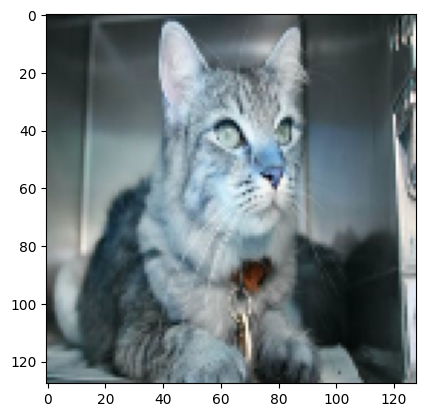

In [131]:
plt.imshow(X_test[3])

---

## PREDICTION:

In [132]:
X_test[0].shape

(128, 128, 3)

In [133]:
def prediction(img):

    img = np.expand_dims(img, axis=0)
    inputs = tf.cast(img, tf.float32)

    conv_output = model(inputs, training=False)

    #print(f'Conv_output: {conv_output}')
    predictions = model.predict(inputs)
    #print(f'Predictions: {predictions[0]}')
    target_class = tf.argmax(predictions[0])
    #print(f'Target Class: {target_class}')
    predicted_class = int((target_class))
    accu = predictions[:, target_class][0]
    #print(f'Accurate (in %): {round(accu*100, 2)}%')


    return predicted_class

In [134]:
prediction(X_test[0])

1/1 [==============================] - 0s 104ms/step


1

In [135]:
y_preds = []
for img in X_test:
    pred = prediction(img) 
    y_preds.append(pred)

1/1 [==============================] - 0s 17ms/step


In [136]:
y_preds = np.array(y_preds)
y_preds

array([1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1])

In [137]:
y_test

array([1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0])

---

## Plotting:

In [156]:
cols = 3
rows = 10

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(128,128))

counter=0
for i in range(rows):
    for j in range(cols):
        index = i*5+j

        pv = 'dog' if y_preds[counter]==1 else 'cat'
        tv = 'dog' if y_test[counter]==1 else 'cat'
         
        axes[i,j].imshow(X_test[counter])
        axes[i,j].set_title(f'Predicted : {pv}\n True value : {tv}', fontsize='64')
        counter += 1
# fig.tight_layout()
fig.subplots_adjust(hspace=1, wspace=0.3)
plt.show()

---

--- end of notebook ---